# 04 – Results and Visualization

This notebook summarizes the final results of the GNN-based link prediction model and generates publication-ready figures:

1. Print the final test AUC and AP.
2. Plot the training curves (loss, validation AUC, validation AP).
3. Visualize the learned node embeddings with t-SNE.
4. Save all figures under `results/figures/`.

In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

%matplotlib inline
plt.style.use("seaborn-v0_8")

# Base paths (this notebook lives in notebooks/)
base_dir = Path("..")
results_dir = base_dir / "results"
data_dir = base_dir / "data"
figures_dir = results_dir / "figures"
figures_dir.mkdir(parents=True, exist_ok=True)

metrics_path = results_dir / "linkpred_metrics.json"
history_path = results_dir / "training_history.json"
emb_path = results_dir / "node_embeddings.pt"
edge_list_path = data_dir / "collaboration.edgelist.txt"

metrics_path, history_path, emb_path, edge_list_path, figures_dir

(PosixPath('../results/linkpred_metrics.json'),
 PosixPath('../results/training_history.json'),
 PosixPath('../results/node_embeddings.pt'),
 PosixPath('../data/collaboration.edgelist.txt'),
 PosixPath('../results/figures'))

## 1. Load final test metrics

We first load the JSON file saved by `train_link_prediction_gnn.py` and print the final test AUC and AP.

In [2]:
if not metrics_path.exists():
    raise FileNotFoundError(f"Metrics file not found: {metrics_path}")

with open(metrics_path, "r") as f:
    metrics = json.load(f)

test_auc = metrics.get("test_auc")
test_ap = metrics.get("test_ap")

print("=== FINAL TEST RESULTS ===")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test AP:  {test_ap:.4f}")
metrics

=== FINAL TEST RESULTS ===
Test AUC: 0.8122
Test AP:  0.8285


{'test_auc': 0.8121775835697238,
 'test_ap': 0.8284574743077475,
 'encoder': 'gcn',
 'epochs': 100}

## 2. Load and inspect training history

The training script stored, for each epoch:

- `epoch`
- `train_loss`
- `val_auc`
- `val_ap`

We load the JSON file and convert it to a pandas DataFrame.

In [3]:
if not history_path.exists():
    raise FileNotFoundError(f"History file not found: {history_path}")

with open(history_path, "r") as f:
    history = json.load(f)

history_df = pd.DataFrame(history)
history_df.head()

,epoch,train_loss,val_auc,val_ap
0,1,0.693744,0.694766,0.748569
1,2,0.691058,0.716165,0.764064
2,3,0.688596,0.723648,0.768943
3,4,0.686189,0.727131,0.771047
4,5,0.683480,0.729233,0.772058


In [4]:
# Show last epochs to confirm convergence
history_df.tail(10)

,epoch,train_loss,val_auc,val_ap
90,91,0.482858,0.804959,0.824598
91,92,0.484712,0.805290,0.824710
92,93,0.481192,0.805641,0.824876
93,94,0.482286,0.806100,0.825224
94,95,0.478633,0.806632,0.825670
95,96,0.478329,0.807160,0.826070
96,97,0.477808,0.807687,0.826404
97,98,0.475888,0.808277,0.826814
98,99,0.472856,0.808954,0.827332
99,100,0.474264,0.809689,0.827902


## 3. Plot training curves

We now reproduce the training curves used in the paper (training loss, validation AUC and validation AP per epoch) and save the resulting figure under `results/figures/fig_training_curves.png`.

Saved training curves figure to: ../results/figures/fig_training_curves.png


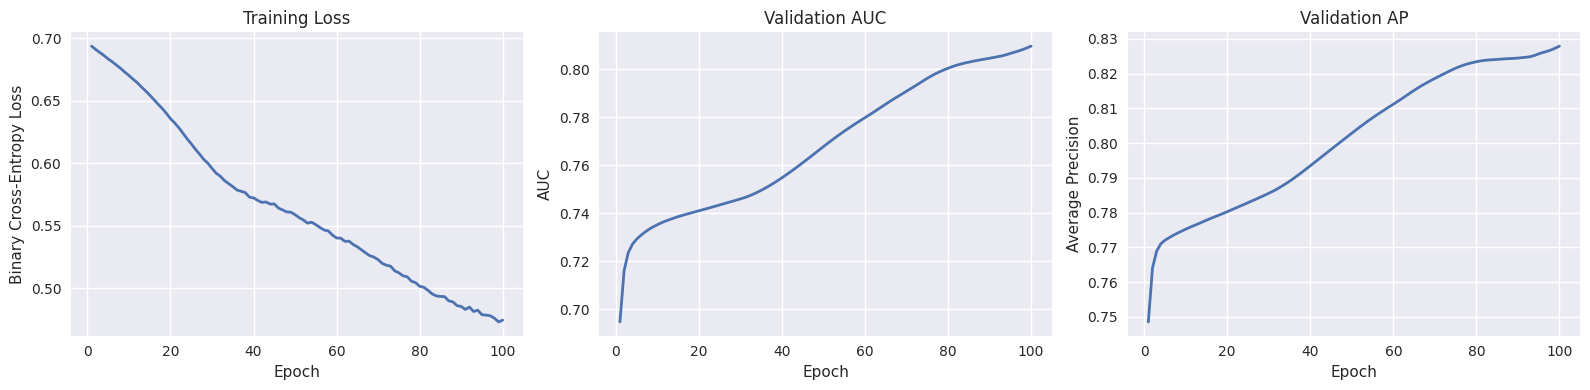

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True)

epochs = history_df["epoch"]

# Training loss
axes[0].plot(epochs, history_df["train_loss"], linewidth=2)
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Binary Cross-Entropy Loss")

# Validation AUC
axes[1].plot(epochs, history_df["val_auc"], linewidth=2)
axes[1].set_title("Validation AUC")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("AUC")

# Validation AP
axes[2].plot(epochs, history_df["val_ap"], linewidth=2)
axes[2].set_title("Validation AP")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Average Precision")

plt.tight_layout()

fig_path = figures_dir / "fig_training_curves.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight")
print(f"Saved training curves figure to: {fig_path}")

## 4. Load node embeddings

We now load the node embeddings saved after training (`results/node_embeddings.pt`) and apply t-SNE to project them to two dimensions. The training script stored a PyTorch tensor with shape `[num_nodes, emb_dim]`.

In [6]:
if not emb_path.exists():
    raise FileNotFoundError(f"Embeddings file not found: {emb_path}")

embeddings = torch.load(emb_path)

# Allow for dict-style checkpoint: {"emb": tensor, ...}
if isinstance(embeddings, dict) and "emb" in embeddings:
    embeddings = embeddings["emb"]

print("Embeddings shape:", embeddings.shape)

# Convert to NumPy
emb_np = embeddings.detach().cpu().numpy()

# For speed, subsample if graph is very large
max_points = 5000
num_points = emb_np.shape[0]

if num_points > max_points:
    rng = np.random.default_rng(42)
    idx = rng.choice(num_points, size=max_points, replace=False)
    emb_sample = emb_np[idx]
    print(f"t-SNE on a subsample of {max_points} nodes out of {num_points}.")
else:
    emb_sample = emb_np
    idx = np.arange(num_points)
    print(f"t-SNE on all {num_points} nodes.")

tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42)
emb_tsne = tsne.fit_transform(emb_sample)
print("t-SNE result shape:", emb_tsne.shape)

Embeddings shape: torch.Size([23133, 64])
t-SNE on a subsample of 5000 nodes out of 23133.
t-SNE result shape: (5000, 2)


## 5. t-SNE visualization of embeddings

Finally, we create a scatter plot of the 2D embeddings. Points correspond to authors; their positions reflect similarity of collaboration patterns captured by the GNN. The figure is saved to `results/figures/fig_tsne_embeddings.png`.

Saved t-SNE figure to: ../results/figures/fig_tsne_embeddings.png


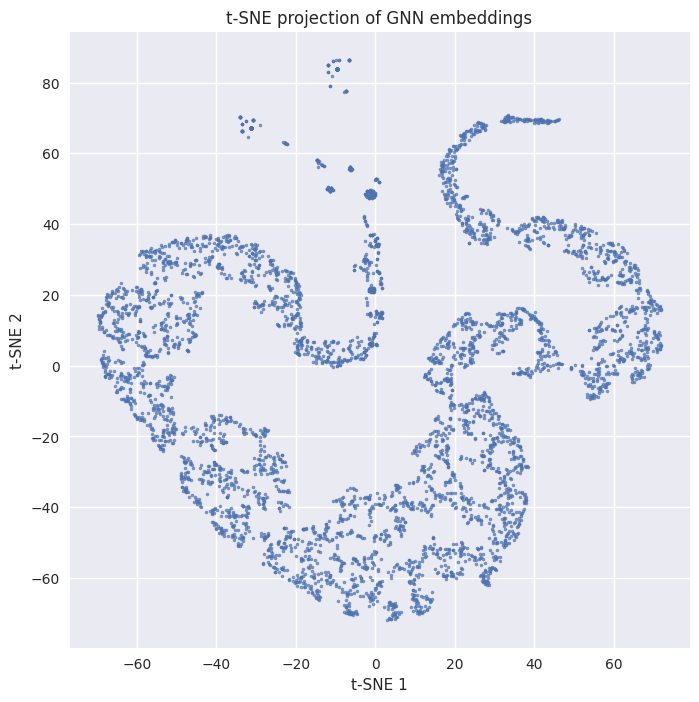

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(emb_tsne[:, 0], emb_tsne[:, 1], s=5, alpha=0.7)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE projection of GNN embeddings")

fig_path_tsne = figures_dir / "fig_tsne_embeddings.png"
fig.savefig(fig_path_tsne, dpi=300, bbox_inches="tight")
print(f"Saved t-SNE figure to: {fig_path_tsne}")

In [8]:
print('Notebook 04 finished successfully. 🚀')

Notebook 04 finished successfully. 🚀
